# Расстояние Махаланобиса

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Данные" data-toc-modified-id="Данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Данные</a></span><ul class="toc-item"><li><span><a href="#Сгенерируем-данные" data-toc-modified-id="Сгенерируем-данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Сгенерируем данные</a></span></li><li><span><a href="#Оценка-математического-ожидания-и-дисперсии" data-toc-modified-id="Оценка-математического-ожидания-и-дисперсии-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Оценка математического ожидания и дисперсии</a></span></li><li><span><a href="#Несмещённые-оценки" data-toc-modified-id="Несмещённые-оценки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Несмещённые оценки</a></span></li><li><span><a href="#Нарисуем-данные" data-toc-modified-id="Нарисуем-данные-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Нарисуем данные</a></span></li></ul></li><li><span><a href="#Расстояние-от-точки-до-класса" data-toc-modified-id="Расстояние-от-точки-до-класса-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Расстояние от точки до класса</a></span><ul class="toc-item"><li><span><a href="#Метрика-Евклида" data-toc-modified-id="Метрика-Евклида-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Метрика Евклида</a></span></li><li><span><a href="#Преобразование-данных" data-toc-modified-id="Преобразование-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Преобразование данных</a></span></li><li><span><a href="#Расстояние-Махаланобиса" data-toc-modified-id="Расстояние-Махаланобиса-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Расстояние Махаланобиса</a></span></li></ul></li><li><span><a href="#Преобразование-данных-с-помощью-SVD" data-toc-modified-id="Преобразование-данных-с-помощью-SVD-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Преобразование данных с помощью SVD</a></span></li><li><span><a href="#Источники" data-toc-modified-id="Источники-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Источники</a></span></li></ul></div>

In [1]:
# Imports
import numpy as np
import scipy.stats as stats
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
# Styles, fonts
import matplotlib
matplotlib.rc('font', size=14)
matplotlib.rc('lines', lw=1., markersize=1.5)
matplotlib.rc('axes', titlesize=16, labelsize=18)
# matplotlib.rcParams['axes.titlesize'] = 16
# matplotlib.rcParams['axes.labelsize'] = 18

cm = plt.cm.tab10  # Colormap

import seaborn
seaborn.set_style('whitegrid')

In [3]:
# import warnings
# warnings.filterwarnings('ignore')

# %config InlineBackend.figure_formats = ['pdf']
# %config Completer.use_jedi = False

---

> **Прасанта Чандра Махаланобис** (1893&ndash;1972) &mdash; индийский математик и статистик, автор способа расчёта расстояния между векторами случайных величин.

## Данные

### Сгенерируем данные

Рассмотрим набор точек, подчиняющихся многомерному нормальному распределению и образующих класс.

In [4]:
N = 1000
mu = np.array([10, 2])

In [5]:
sig = np.array([1.5, 0.5])   # Principal axes
theta = np.pi/6              # Rotate cloud by pi/3
R = np.array([[np.cos(theta), -np.sin(theta)],     # Rotation matrix
              [np.sin(theta),  np.cos(theta)]])
P = (R @ np.diag(sig) @ np.random.randn(2,N) + np.diag(mu) @ np.ones((2,N))).T

print(P.shape)
print(P[:5])
# np.savetxt('points_mvn.csv', data, delimiter=',')

(1000, 2)
[[ 7.83525961  0.39712395]
 [11.56679432  2.87763789]
 [11.45007067  2.7348413 ]
 [ 9.27994905  1.39261187]
 [11.12038794  1.90310423]]


Обратим внимание на компоновку матрицы объекты-признаки $P$.
Её размер $N \times 2$, т.е. признаки (координаты точек) являются столбцами, а объекты (точки) &mdash; строками.
Это привычное расположение объектов и признаков, однако оно не совсем удобно для преобразований координат точек.
Например, чтобы сделать преобразование $M$, приходится транспонировать матрицу с объектами: $(M P^\top)^\top$.
Определим для этих действий функцию `transform`.

In [6]:
def transform(points, M):
    return (M @ points.T).T

In [7]:
# the second way to make points matrix is to take samples from a multivariate normal distribution
# cov = np.array([[1.807, 0.929], [0.929, 0.809]])  # covariance matrix of x and y
# P2 = stats.multivariate_normal.rvs(mu, cov, size=N, random_state=42)

In [8]:
L_lim = 4.
limits = np.tile([-L_lim, L_lim], (2, 1))
limits += mu.reshape(-1,1)

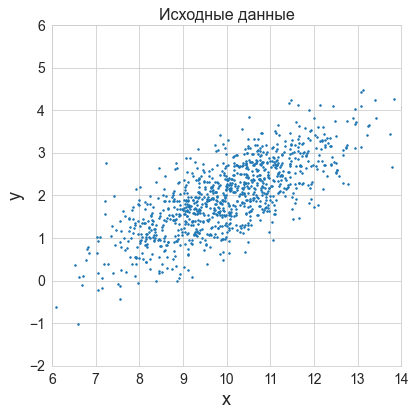

In [9]:
title='Исходные данные'
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot( P[:,0],  P[:,1], 'o')
# ax.plot(P2[:,0], P2[:,1], 'o')
ax.set(xlim=limits[0], ylim=limits[1])
ax.set(xlabel='x', ylabel='y', title=title)
plt.tight_layout()
plt.show()

### Оценка математического ожидания и дисперсии

Основываясь на данных, как на выборке из генеральной совокупности, сделаем оценку математического ожидания и дисперсии.

Оценка математического ожидания:

$$ \hat{\mu} = \dfrac{1}{n} \sum_{i}^{n} x_i .$$

Оценка дисперсии:

$$ \hat{\sigma}^2_n =  \dfrac{1}{n} \sum_{i}^{n} (x_i - \hat{\mu})^2 .$$

Аналогично строится оценка для ковариационной матрицы:

$$ \hat{\Sigma}_n =  \dfrac{1}{n} \sum_{i}^{n} (x_i - \hat{\mu}) (x_i - \hat{\mu})^\top .$$

### Несмещённые оценки

Точечная оценка, математическое ожидание которой равно оцениваемому параметру, называется *несмещённой*.

**Определение.** Пусть $X^n = (x_1, \ldots, x_n)$ &mdash; выборка случайных независимых наблюдений, из распределения $\varphi$, зависящего от параметра $\theta$.
Оценка $\hat{\theta}(X^n)$ параметра $\theta$, вычисленная по выборке $X^n$, называется несмещённой, если $\mathrm{E} \hat{\theta}(X^n) = \theta$.

Покажем *смещённость выборочной дисперсии*

Найдём математическое ожидание выборочной дисперсии:

$$
\mathrm{E}[\hat{\sigma}^2_n] = \mathrm{E}\left[ \dfrac{1}{n} \sum_{i}^{n} (x_i - \hat{\mu})^2 \right].
$$


Добавим и вычтем $\mu$, затем возведём в квадрат и упростим выражение:

$$
\mathrm{E}[\hat{\sigma}^2_n]
= \mathrm{E} \left[ \dfrac{1}{n} \sum_{i}^{n} \left( (x_i - \mu) - (\hat{\mu} - \mu) \right)^2 \right]
= \mathrm{E} \left[ \dfrac{1}{n} \sum_{i}^{n} \left( (x_i - \mu)^2 - 2(x_i - \mu)(\hat{\mu} - \mu) + (\hat{\mu} - \mu)^2 \right) \right]
= \mathrm{E} \left[ \dfrac{1}{n} \left( \sum_{i}^{n}(x_i - \mu)^2 - 2(\hat{\mu} - \mu) \sum_{i}^{n}(x_i - \mu) + n(\hat{\mu} - \mu)^2 \right) \right]
= \mathrm{E} \left[ \dfrac{1}{n} \sum_{i}^{n}(x_i - \mu)^2 - (\hat{\mu} - \mu)^2 \right]
.
$$


Заметив, что $\mathrm{E} \left[ \dfrac{1}{n} \sum_{i}^{n}(x_i - \mu)^2 \right] = \sigma^2$ и $\mathrm{E} \left[ (\hat{\mu} - \mu)^2 \right] = \dfrac{1}{n} \sigma^2$, получим:

$$
\mathrm{E}[\hat{\sigma}^2_n] = \sigma^2 - \dfrac{1}{n} \sigma^2 = \dfrac{n-1}{n} \sigma^2
$$

Таким образом, оценка дисперсии является смещённой.

Для учёта смещения вводится *исправленная выборочная дисперсия*:

$$ \hat{\sigma}^2 =  \dfrac{1}{n-1} \sum_{i}^{n} (x_i - \hat{\mu})^2 .$$


Такая же поправка на смещение вводится и для ковариационной матрицы:

$$ \hat{\Sigma} =  \dfrac{1}{n-1} \sum_{i}^{n} (x_i - \hat{\mu}) (x_i - \hat{\mu})^\top .$$

Теперь сделаем все эти оценки для рассматриваемой выборки.

In [10]:
mu_estimate = np.mean(P, axis=0)
print('Оценка математического ожидания:')
print(mu_estimate)

Оценка математического ожидания:
[10.00674318  1.98943428]


In [11]:
# mean-subtracted data
P_c = P - mu_estimate

cov_estimate_n = P_c.T @ P_c / N
print('\nСмещённая оценка ковариационной матрицы:')
print(cov_estimate_n)

cov_estimate = P_c.T @ P_c / (N-1)
print('\nНесмещённая оценка ковариационной матрицы:')
print(cov_estimate)


Смещённая оценка ковариационной матрицы:
[[1.89551767 0.90674078]
 [0.90674078 0.75370583]]

Несмещённая оценка ковариационной матрицы:
[[1.89741509 0.90764843]
 [0.90764843 0.75446029]]


Мы можем убедиться, что для выборки большого размера смещение мало.

### Нарисуем данные

In [12]:
def make_ellipse(mu, cov, ci=0.95, color='gray'):
    """Make covariance isoline"""
    e, v = np.linalg.eig(cov)
    angle = np.sign(v[1, 0]) * 180/np.pi * np.arccos(v[0, 0])
    q = stats.chi2(2).ppf(ci)
    label = f'{100*ci:.3g}% ci'
    e = Ellipse(mu, 2*np.sqrt(q*e[0]), 2*np.sqrt(q*e[1]), angle=angle,
                fill=False, color=color, label=label)
    return e

In [13]:
def draw_data(data, mu, cov, points, limits, title=''):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(data[:, 0], data[:, 1], 'o')
    colors = [1, 3]
    for i, (p, c) in enumerate(zip(points, colors)):
        ax.plot(*zip(mu, p), '--x', c=cm(c), ms=10, mew=2.)
        ax.text(*p, i+1)
    ci_list = [stats.chi2(2).cdf(i**2) for i in range(1,4)]
    for ci in ci_list:
        e = make_ellipse(mu, cov, ci=ci)
        ax.add_artist(e)
    ax.plot(*mu, 'kx', ms=10, mew=2.)
              
    ax.set(xlim=limits[0], ylim=limits[1])
    ax.set(xlabel='x', ylabel='y', title=title)
    plt.tight_layout()
    plt.show()

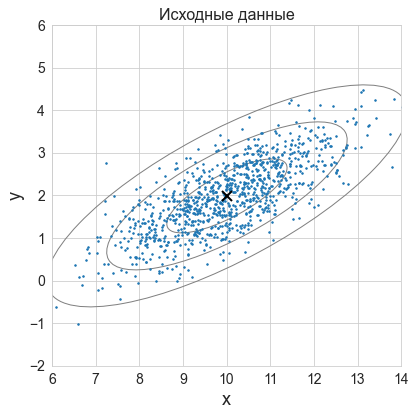

In [14]:
mu  = mu_estimate
cov = cov_estimate
draw_data(P, mu, cov, [], limits, title)

Серым цветом на рисунке обозначены линии $1\sigma$, $2\sigma$ и $3\sigma$.

---

## Расстояние от точки до класса

### Метрика Евклида

Теперь нас будет интересовать расстояние от произвольной точки до &laquo;центра масс&raquo; класса (выборочного среднего). \
Сначала в качестве меры расстояния рассмотрим метрику Евклида.

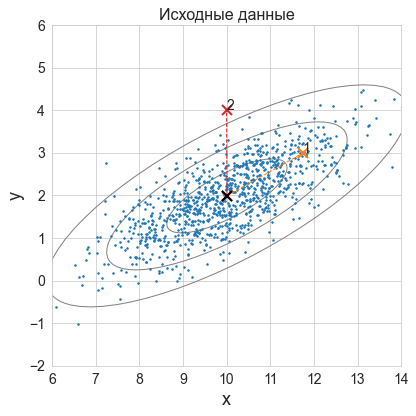

In [15]:
points = (R @ np.array([[2, 0], [1.0, 1.75]]).T).T + mu
draw_data(P, mu, cov, points, limits, title)

In [16]:
for i, point in enumerate(points):
    dist = np.linalg.norm(point - mu)
    print(f'Точка {i+1}, d_E = {dist:.4}')

Точка 1, d_E = 2.0
Точка 2, d_E = 2.016


С точки зрения евклидовой метрики точки расположены практически равноудалённо от центра.
Хотя с точки зрения здравого смысла мы понимаем, что это не так.
Первая точка гораздо более типична для распределения, чем вторая.

Чтобы восстановить справедливость, преобразуем данные так, чтобы убрать корреляцию и привести к единице дисперсию.

### Преобразование данных

Центрируем данные.

In [17]:
mu_c = mu - mu
points_c = points - mu
limits_c = limits - mu.reshape(-1,1)

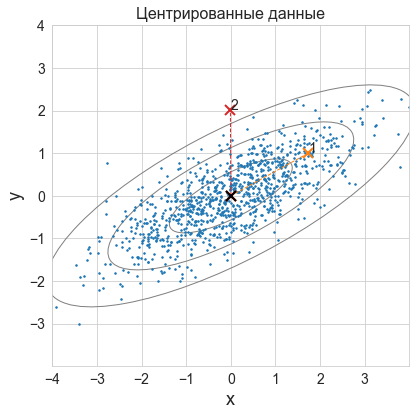

In [18]:
title = 'Центрированные данные'
draw_data(P_c, mu_c, cov, points_c, limits_c, title=title)

Сделаем спектральное разложение ковариационной матрицы.
(Помним, что ковариационная матрица является симметричной и положительно определённой.)

In [19]:
# spectral decomposition
lmbd, Q = np.linalg.eig(cov)
print(lmbd)
print(Q)

[2.39851034 0.25336504]
[[ 0.87544559 -0.48331668]
 [ 0.48331668  0.87544559]]


Теперь уберём в данных корреляцию.

In [20]:
P_m   = transform(P_c, Q.T)
points_m = transform(points_c, Q.T)

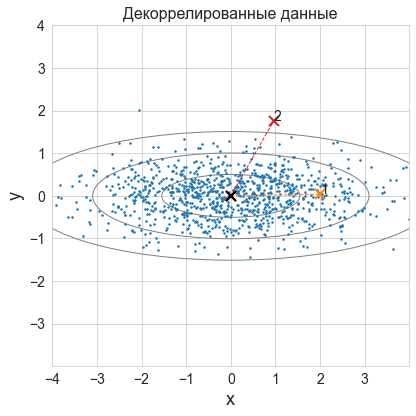

In [21]:
title = 'Декоррелированные данные'
draw_data(P_m, mu_c, Q.T@cov@Q, points_m, limits_c, title=title)

И сделаем у данных единичную дисперсию.

In [22]:
Lmbd_inv = np.diag(1./lmbd**0.5)
Q2 = Lmbd_inv @ Q.T   # transformation matrix
print(Lmbd_inv)

P_m = transform(P_c, Q2)
points_m = transform(points_c, Q2)

[[0.64569765 0.        ]
 [0.         1.9866742 ]]


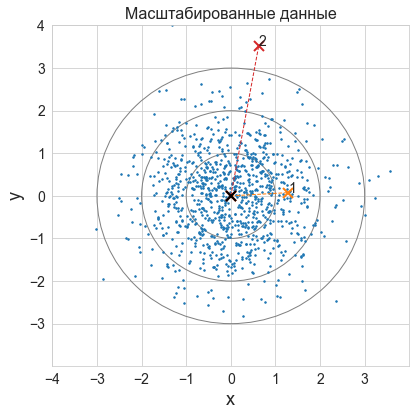

In [23]:
title='Масштабированные данные'
draw_data(P_m, mu_c, Q2@cov@Q2.T, points_m, limits_c, title=title)

И теперь уже вычислим расстояния.

In [24]:
for i, point in enumerate(points_m):
    dist = np.linalg.norm(point)
    print(f'Точка {i+1}, d_M = {dist:.4}')

Точка 1, d_M = 1.293
Точка 2, d_M = 3.569


Мы получили расстояние Махаланобиса.

### Расстояние Махаланобиса

Расстояние Махаланобиса можно интерпретировать как новое скалярное произведение с матрицей Грамма, равной обратной ковариационной матрице.
Следовательно, данная метрика позволяет устранить проблемы, связанные с масштабом и корреляцией, присущие расстоянию Евклида.

Попробуем установить данный факт математически. <br>
*Метрика Махаланобиса* $d_{M}(x, y, \Sigma) = \sqrt{(x - y)^T \Sigma^{-1}(x - y)}$, здесь $\Sigma^{-1}$ &mdash; обратная ковариационная матрица. \
*Ковариационная матрица* &mdash; симметричная положительно полуопределённая матрица. \
*Спектральное разложение матрицы* $\Sigma = Q \Lambda Q^\top$ (так как матрица симметричная). По смыслу $Q$ &mdash; матрица перехода, где столбцами являются собственные векторы, $\Lambda$ &mdash; матрица собственных чисел.

$$ \Sigma^{-1} = (Q \Lambda Q^\top)^{-1} = Q \Lambda^{-1} Q^\top = (Q \Lambda^{-1/2}) (\Lambda^{-1/2} Q^\top) $$

Подставим это в расстояние Махаланобиса : $d_{M}(x, y) = \sqrt{(Q^\top(x - y))^\top \Lambda^{-1}(Q^\top(x - y))} = \sqrt{(\tilde{x} - \tilde{y})^T \Lambda^{-1}(\tilde{x} - \tilde{y})}$.

Таким образом мы перешли в пространство, используя ортогональное преобразование с сохранением расстояния, при котором новая матрица Грамма равна $\Lambda^{-1}$. \
Новый базис &mdash; ортогональный.
Новая матрица $\Lambda^{-1}$ приводит к тому, что каждая компонента векторов $\tilde{x}, \tilde{y}$ нормируется особым индивидуальным образом, тем самым вносит равновесомый вклад в вычисляемое расстояние, и невозможна ситуация, когда &laquo;расстояние вдоль одной оси (координаты) доминирует над расстоянием вдоль другой&raquo; (что безусловно бывает при вычислении метрики Евклида).

In [25]:
def dist_Mahalanobis(x, y, cov):
    return ((x-y).T @ np.linalg.inv(cov) @ (x-y))**0.5

In [26]:
for i, point in enumerate(points):
    dist = dist_Mahalanobis(point, mu, cov)
    print(f'Точка {i+1}, d_M = {dist:.4}')

Точка 1, d_M = 1.293
Точка 2, d_M = 3.569


Таким образом, можно думать о метрике Махаланобиса как о совокупности *1) линейного преобразования исходных осей в равномасштабные координаты (вместе с нормировкой на собственные числа)* и *2) вычисления в новых равноценных переменных расстояния Евклида.* <br>

Дополнительно про расстояние Махаланобиса можно почитать [здесь](https://ru.qaz.wiki/wiki/Mahalanobis_distance). <br>


---

## Преобразование данных с помощью SVD

Проделаем те же преобразования данных с помощью SVD, не используя ковариационную матрицу.

In [27]:
U, sgm, Vt = np.linalg.svd(P_c, full_matrices=False)
Vt[:,0] *= -1
print('lmbd =', lmbd)
sgm *= (N-1)**-0.5
print('sgm**2 =', sgm**2)
print(Vt)

lmbd = [2.39851034 0.25336504]
sgm**2 = [2.39851034 0.25336504]
[[-0.87544559  0.48331668]
 [-0.48331668 -0.87544559]]


In [28]:
V = Vt.T
P_m   = transform(P_c, V)
points_m = transform(points_c, V)

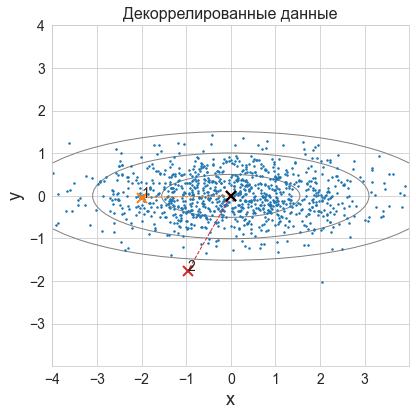

In [29]:
title = 'Декоррелированные данные'
draw_data(P_m, mu_c, V@cov@Vt, points_m, limits_c, title=title)

In [30]:
Sgm_inv = np.diag(1./sgm)
Q3 = Sgm_inv @ V   # transformation matrix
print(Sgm_inv)

P_m   = transform(P_c, Q3)
points_m = transform(points_c, Q3)

[[0.64569765 0.        ]
 [0.         1.9866742 ]]


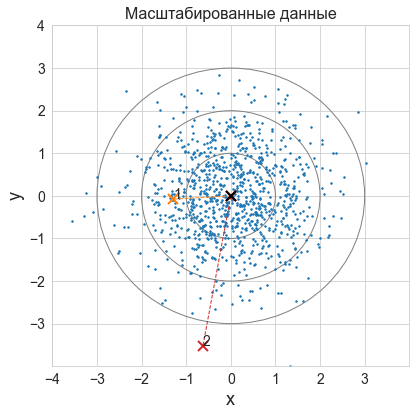

In [31]:
title='Масштабированные данные'
draw_data(P_m, mu_c, Q3@cov@Q3.T, points_m, limits_c, title=title)

In [32]:
for i, point in enumerate(points_m):
    dist = np.linalg.norm(point)
    print(f'Точка {i+1}, d_M = {dist:.4}')

Точка 1, d_M = 1.293
Точка 2, d_M = 3.569


---

## Источники

**Добавить**


In [33]:
# Versions used
import sys
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print(f'numpy: {np.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {seaborn.__version__}')

Python: 3.7.11
numpy: 1.20.3
matplotlib: 3.5.1
seaborn: 0.11.2
